## Announcements

* TODAY: Literature Review
* Next week: Midterm 1
* 2/10/17: Womework 1


# Regression

Guillermo Cabrera

gcabrera@dim.uchile.cl

linear regression, ridge regression/LASSO & regularization, bias/variance tradeoff, overfitting,

## The Regression Problem

Given a dataset $\{(\boldsymbol{x}_1,y_1),(\boldsymbol{x}_2,y_2),\cdots, (\boldsymbol{x}_N,y_N)\}$, we want to determine a function $f : X\rightarrow Y$  that predicts the output value of new data as $y = f(\boldsymbol{x})$. $\boldsymbol{x}_i\in X$ are vectors and we will consider $y_i\in Y$ to be scalars. When $Y= \mathbb{R}$ we call it regression.

Regression addresses the problem of infering the expectation value of $y$ given $\boldsymbol{x}$ (i.e., the conditional expectation value). This is usually achieved by using a regression model which depends on some parameters $\boldsymbol{\theta}$. We can write this function as $y = f(\boldsymbol{x}|\boldsymbol{\theta})$.

From a probabilistic point of view, we want to obtain the model (described by $\boldsymbol{\theta}$) that maximises the probability of $\theta$ given the data $\{\boldsymbol{x}_i, y_i\}$ and the information $I$ describing the behaviour of the errors, i.e.

$\max_\boldsymbol{\theta}p(\boldsymbol{\theta}|\{\boldsymbol{x}_i, y_i\}, I)$.

Lets consider some basic assumptions:
* error behaviour of the dependent variables is known
* errors for the independent variables are negligible
* independence of data points

Using Bayes theorem:

$p(\boldsymbol{\theta}|\{\boldsymbol{x}_i, y_i\}, I)\propto p(\{x_i, y_i\}|\boldsymbol{\theta}, I)p(\boldsymbol{\theta}, I) \propto \prod_{i=1}^N p(y_i|x_i,\boldsymbol{\theta}, I)p(\boldsymbol{\theta}, I)$,

We call $\prod_{i=1}^N p(y_i|x_i,\boldsymbol{\theta}, I)$ the likelihood, and $p(\boldsymbol{\theta}, I)$ the prior.

Lets see a toy regression problem: we'll see the dependency of galaxy distances with respect to the redshift using Supernovae data. For this, we have already downloaded a dataset for supernovae from the "Supernova Cosmology Project":http://supernova.lbl.gov/Union/ that contains redshifts, distance modulus, and errors. The distance modulus $\mu = m - M$ is basically the difference between the apparent magnitude $m$ (ideally, corrected from the effects of interstellar absorption) and the absolute magnitude $M$ of an astronomical object, and is related to the distance in parsecs $d$ as $\log_{10}(d) = 1 - \frac{\mu}{5}$. This data is useful to regress the Lambda cold dark matter model, which is a parametrization of the Big Bang cosmological model.

We will play with this data and try different regression algorithms.

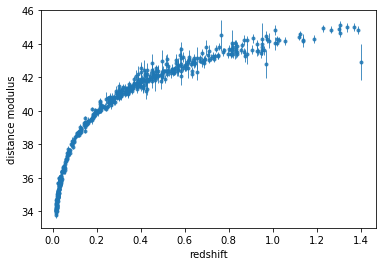

In [49]:
%matplotlib inline

import sys
import numpy as np
import pylab as pl
import pandas as pd

df = pd.read_csv("data/Supernovae.csv")

# shuffle the data
df = df.reindex(np.random.permutation(df.index))

pl.clf()
pl.errorbar(df['z'], df['mu'], ls = "None", yerr = df['sigma_mu'], 
            lw = 1, fmt = ".", alpha = 0.8)
pl.xlabel ("redshift")
pl.ylabel("distance modulus")

## Linear Regression

When a model is linear in terms of its parameters, the problem becomes significantly simple.

$f(\boldsymbol{x}|\boldsymbol{\theta}) = \sum_{p=1}^{k}\theta_pg_p(\boldsymbol{x})$,

where $g_p(\boldsymbol{x})$ may not be linear in terms of $\boldsymbol{x}$ and does not depend on $\boldsymbol{\theta}$. Examples of this are polinomial regression, radial basis function regression, or Fourier series regression.

### Linear Model

Consider the simplest case: a linear model

$y_i = \theta_0+\theta_1x_i+\epsilon_i$,

where $\theta_0$ and $\theta_1$ are the regression coefficients we will try to estimate, and $\epsilon_i$ represents an error term. We will consider the uncertainties of the independent variable $x$ to be negligible, and the dependent variables to have known heteroscedastic (different) uncertainties, $\epsilon = N(0, \sigma_i)$. Given these assumptions, then

$p(y_i|x_i, \boldsymbol{\theta}, I) = \frac{1}{\sigma_i\sqrt{2\pi}}\exp\left(\frac{-[y_i -f(x_i|\boldsymbol{\theta})]^2}{2\sigma_i^2}\right)$,

where $I$ represents the information describing the error behaviour for the dependent variable. Assuming all data points are independent, then we can write the data likelihood as

$p(\{y_i\}|\{x_i\},\boldsymbol{\theta}, I) = \prod_{i=1}^{N}\frac{1}{\sigma_i\sqrt{2\pi}}\exp\left(\frac{-[y_i -f(x_i|\boldsymbol{\theta})]^2}{2\sigma_i^2}\right)= \prod_{i=1}^{N}\frac{1}{\sigma_i\sqrt{2\pi}}\exp\left(\frac{-[y_i -(\theta_0+\theta_1x_i+\epsilon_i)]^2}{2\sigma_i^2}\right)$.

If we have no knowledge about the distribution of $\boldsymbol{\theta}$, we use a flat (or uninformative) prior $p(\boldsymbol{\theta}, I)$. In this case, the posterior will be proportional to the likelihood function. For easy computation, we cap use the logarithm of the posterior arriving to the expression for the log-likelihood:

$\ln(L) \equiv \ln(p(\{y_i\}|\{x_i\},\boldsymbol{\theta}, I)) = \sum_{i=1}^N\left(\frac{-[y_i -(\theta_0+\theta_1x_i+\epsilon_i)]^2}{2\sigma_i^2}\right)$.

Lets consider the problem in matrix notation. We will define

$Y = \begin{pmatrix}
y_1\\
y_2\\
\vdots\\
y_N
\end{pmatrix}$,

$\boldsymbol{\theta} = \begin{pmatrix}
\theta_0\\
\theta_1
\end{pmatrix}$

$M = \begin{pmatrix}
1 & x_1\\
1 & x_2\\
\vdots & \vdots\\
1 & x_N
\end{pmatrix}$

$C = \begin{pmatrix}
\sigma_1^2 & 0 & \ldots & 0\\
0 & \sigma_2^2 & \ldots & 0\\
\vdots & \vdots & & \vdots\\
0 & 0 & \ldots & \sigma_N^2
\end{pmatrix}$

Using this notation, the log-likelihood can be written as
$\ln(L) = (Y - M\boldsymbol{\theta})^TC^{-1}(Y-M\boldsymbol{\theta})$, and the maximum likelihood estimate for the model parameters is

$\boldsymbol{\theta} = (M^TC^{-1}M)^{-1}(M^TC^{-1}Y)$.

Lets try a simple code for the supernovae data:


In [50]:
# For simplicity, we will select only 30 points from the dataset.
N = 30
df_sm = df.sample (N)
print df_sm


         SN         z         mu  sigma_mu
440    f096  0.412000  41.423251  0.315187
136  2006ot  0.052200  36.664355  0.182864
279  2005mi  0.214000  40.098371  0.132159
241  2005ht  0.187000  39.836628  0.121451
3     1993b  0.070086  37.440321  0.158669
524  2001gy  0.511000  42.388163  0.089912
157  2008af  0.034100  35.760433  0.170423
411  03D1fl  0.688000  43.070496  0.166957
488  1999ff  0.455000  42.338362  0.232259
273  2005jw  0.381000  41.445539  0.148158
397  04D3ny  0.810000  43.373778  0.215182
447    g050  0.633000  42.210722  0.261566
338  1999dv  0.186000  39.720560  0.197086
99   2005ki  0.020400  34.712514  0.188559
504   05Zwi  0.521000  42.387525  0.184038
159   2008l  0.018900  34.376778  0.203803
429    e108  0.469000  42.370269  0.283065
123  2006ej  0.019200  34.728588  0.191425
523  2001gq  0.671000  42.991417  0.121927
158  2008bf  0.025100  34.939305  0.171896
383  04D3fk  0.357800  41.421472  0.136957
52   1999ar  0.156100  39.227737  0.083180
435    e148

[[ 0.412   ]
 [ 0.0522  ]
 [ 0.214   ]
 [ 0.187   ]
 [ 0.070086]
 [ 0.511   ]
 [ 0.0341  ]
 [ 0.688   ]
 [ 0.455   ]
 [ 0.381   ]
 [ 0.81    ]
 [ 0.633   ]
 [ 0.186   ]
 [ 0.0204  ]
 [ 0.521   ]
 [ 0.0189  ]
 [ 0.469   ]
 [ 0.0192  ]
 [ 0.671   ]
 [ 0.0251  ]
 [ 0.3578  ]
 [ 0.1561  ]
 [ 0.429   ]
 [ 0.655   ]
 [ 1.307   ]
 [ 0.104   ]
 [ 0.032   ]
 [ 0.522   ]
 [ 0.0215  ]
 [ 0.124   ]]


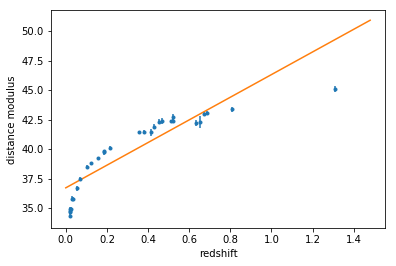

In [51]:
# We will use the linear regression model from scikit-learn
from sklearn.linear_model import LinearRegression

# The following function creates the polynomial design matrix.
def polynomial_basis (x, degree):
    p = np.arange (1, degree + 1)
    return x[:, np.newaxis] ** p

# We create the design matrix of a polynomial of 1 degree.
X = polynomial_basis (df_sm["z"], 1)
print X

# Now, we create a linear regression model and fit it to the data.

model = LinearRegression()
model.fit (X, df_sm["mu"], sample_weight = 1./df_sm["sigma_mu"])

# We create an array of fitted values.
x = np.arange(0, 1.5, 0.02)
y1 = model.predict(polynomial_basis(x, 1))

# And plot
pl.clf()
pl.errorbar(df_sm['z'], df_sm['mu'],fmt = ".", yerr = df_sm['sigma_mu'])
pl.plot(x, y1)
pl.xlabel ("redshift")
pl.ylabel("distance modulus")

### Polynomial Regression

Now, lets consider a polynomial model:

$y_i =\theta_0 + \theta_1x_i + \theta_2x_i^2 + \cdots + \theta_kx_i^k +\epsilon_i$

This model can be fitted using the above methodology with an expanded design matrix

$M = \begin{pmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^k\\
1 & x_2 & x_2^2 & \cdots & x_2^k\\
\vdots & \vdots & \vdots & & \vdots\\
1 & x_N & x_N^2 & \cdots & x_N^k
\end{pmatrix}$

Lets try a polynomial fit over the supernovae data.

34.6422359763 [ 34.21344071 -47.02296854  20.73487142]
33.7544233616 [  60.45496979 -205.57614422  370.69354216 -317.49387662  100.2559839 ]


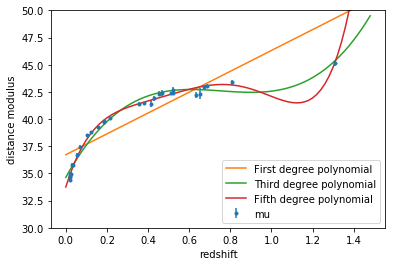

In [52]:
# We define a polynomial of 3rd degree and fit it to the data.
p3_model = LinearRegression()
p3_model.fit(polynomial_basis (df_sm["z"], 3), df_sm["mu"], sample_weight = 1./df_sm["sigma_mu"])
print p3_model.intercept_, p3_model.coef_

# Now we predict for x
y3 = p3_model.predict(polynomial_basis (x, 3))

# We define a polynomial of 5th degree and fit it to the data.
p5_model = LinearRegression()
p5_model.fit(polynomial_basis (df_sm["z"], 5), df_sm["mu"], sample_weight = 1./df_sm["sigma_mu"])
print p5_model.intercept_, p5_model.coef_

# Now we predict for x
y5 = p5_model.predict(polynomial_basis (x, 5))

pl.clf()
#pl.plot(z, mu,"o", markersize = 3, alpha = 0.5)
pl.errorbar(df_sm['z'], df_sm['mu'],fmt = ".", yerr = df_sm['sigma_mu'])
pl.plot(x, y1, label = "First degree polynomial")
pl.plot(x, y3, label = "Third degree polynomial")
pl.plot(x, y5, label = "Fifth degree polynomial")
pl.xlabel ("redshift")
pl.ylabel("distance modulus")
pl.legend(loc = "lower right")
pl.ylim([30, 50])
pl.show()



In the above plot we can see that the highest the degree of the polynomial, the more flexible the model is, hence improving the fit. But by arbitrarily increasing the degree of the polynomial, we may overfit the data.

Question arising: 
* How complex should the model be?

The polynomial model can de generalized to a basis function representation by noting that each row of the design matrix can be replaced with any linear or non-linear function:

$M = \begin{pmatrix}
1 & g_1(x_1) & g_2(x_1) & \cdots & g_k(x_1)\\
1 & g_1(x_2) & g_2(x_2) & \cdots & g_k(x_2)\\
\vdots & \vdots & \vdots & & \vdots\\
1 & g_1(x_N) & g_2(x_N) & \cdots & g_k(x_N)
\end{pmatrix}$


## Bias-Variance Tradeoff

* Consider a dataset $\{(\boldsymbol{x}_i, y_i)\}_{i=1}^N$. 
* Lets assume there exists a functional noisy relation $y = f(\boldsymbol{x}) + \epsilon$, where the noise $\epsilon$ has zero mean and standard deviation $\sigma$. 
* By using regression, we approximate the true function $f(\boldsymbol{x})$ using an estimated function $\hat{f}(\boldsymbol{x})$. 
* Ideally, our estimated model would minimize the mean square error (MSE) $\mathrm{MSE}(\boldsymbol{x}) = \mathbb{E}((y - \hat{f}(\boldsymbol{x}))^2)$ both for our dataset $\{(\boldsymbol{\boldsymbol{x}}_i, y_i)\}_{i=1}^N$ and for points outside of our sample. 
* In practice this can not be done perfectly because of the noise contained in $y_i$. 
* This means there will always be an error on our estimated model. 
* For whichever model we chose (or fit) we can decompose its expected error over unseen data as

$\mathrm{MSE}(x) = \mathbb{E}((y - \hat{f}(x))^2) = \mathrm{bias}_x^2 + \mathrm{variance}_x + \sigma^2$, where

$\mathrm{bias}_x = \mathbb{E}(\hat{f}(x))- f(x)$

$\mathrm{variance}_x = \mathrm{Var}(\hat{f}(x)) = \mathbb{E}[\left(\hat{f}(x) - \mathbb{E}[\hat{f}(x)]\right)^2]$

$\sigma$ = standard deviation of the noise.

The above equation says there will always be a tradeoff between the bias and the variance of our fitted model. This is what we call the *bias-variance tradeoff*. This tradeoff is easily obtained from the definition of the MSE:

Definition: The MSE of an estimator $\hat{f}(D)$ for $f$, where $D$ represents (random) data, is $\mathrm{MSE}(\hat{f}) = \mathbb{E}_D ((\hat{f} - y)^2)$

$\begin{eqnarray}
\mathrm{MSE}(\hat{f}) & = & \mathbb{E}_D ((\hat{f} - y)^2)\\
 & = & \mathbb{E}_D (\hat{f}^2 - 2\hat{f}y + y^2) \\
 & = & \mathbb{E}_D (\hat{f}^2) - 2f\mathbb{E}_D (\hat{f}) + \mathbb{E}_D (y^2)\\
 & = & [\mathrm{Var}_D(\hat{f}) + \mathbb{E}_D(\hat{f})^2] - 2f\mathbb{E}_D (\hat{f}) +[\mathrm{Var}_D(y) + \mathbb{E}_D(y)^2]\\
  & = & \mathrm{Var}_D(\hat{f}) + (\mathbb{E}_D (\hat{f}) - f)^2 +\mathrm{Var}_D(y)\\
  & = & \mathrm{variance} + \mathrm{bias}^2 + \sigma^2
\end{eqnarray}$

Consider a regression model that fits perfectly the *training data* (e.g. high order polynomial). This complex model will have a high variance when regressing new data. On the other hand, a model too simple will have very low variance, but at the same time it will have a high bias. 

Lets see this by creating a simple regression problem for a sinusoid $f(x) = \cos{2*x}$ and homoscedastic errors with $\sigma = 0.1$



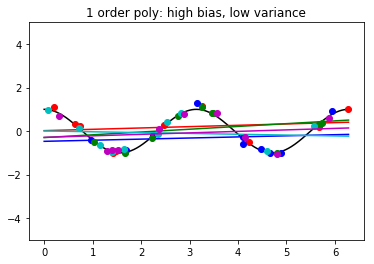

In [53]:
# We create a couple of vectors with the true function.
x_cos = np.arange(0, 2*np.pi, 0.01)
y_cos = np.cos(2*x_cos)

# We define the noise and the number of data samples following such function.
sigma_noise = 0.1
N = 5

# We define a polynomial of 1 degree (linear).
p1_model = LinearRegression()

# Plot the true function.
pl.clf()
pl.plot(x_cos, y_cos, "k")
colors = ['r', 'b', 'g', 'c', "m", "y"]

# We run N iterations drawing 10 data points in each and fit a constant function.
for i in range(N):
    x_data = np.random.random(10)*2*np.pi
    y_data = np.cos(2*x_data) + np.random.normal(scale = sigma_noise, size = 10)

    p1_model.fit(polynomial_basis (x_data, 1), y_data)
    y1 = p1_model.predict(polynomial_basis (x_cos, 1))

    pl.plot(x_data, y_data, "o" + colors[i])
    pl.plot (x_cos, y1, colors[i])
    
pl.title ("1 order poly: high bias, low variance")
pl.ylim ([-5, 5])    
pl.show()



For this very simple 1st order polynomial (i.e. a constant value), the variance between models in terms of different datasets is relatively small, while the difference between the expected value of the model and the real function (bias) is high. 

Now lets try fitting a really complex model.

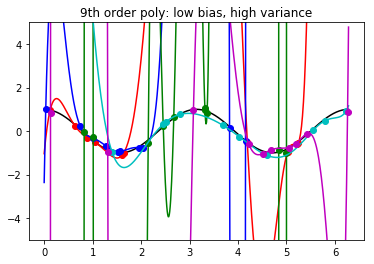

In [54]:
# We define a polynomial of 10th degree (linear).
p10_model = LinearRegression()

pl.clf()
pl.plot(x_cos, y_cos, "k")
# We run N iterations drawing 10 data points in each and fit a 8th degree polynomial function. 
for i in range(N):
    x_data = np.random.random(10)*2*np.pi
    y_data = np.cos(2*x_data) + np.random.normal(scale = sigma_noise, size = 10)

    p10_model.fit(polynomial_basis (x_data, 10), y_data)
    y10 = p10_model.predict(polynomial_basis (x_cos, 10))

    pl.plot(x_data, y_data, "o" + colors[i])
    pl.plot (x_cos, y10, colors[i])
pl.title ("9th order poly: low bias, high variance")
pl.ylim ([-5, 5])
pl.show()

In this case, the expected value of the model (average of all different models) is very close to the real funcion, i.e. low bias, but the variance of the models is huge!

In general, the more biased our model is, the lowest the variance, and vice versa. In that sense, we need to find a proper tradeoff between bias and variance sucha that the MSE is minimum.

<img src = http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png/>


## Regularization

So far, we have focused on fitting models by minimizing the mean square errors between the model and the data. The Gauss-Markov theorem states that this leads to the lowest variance unbiased model (bias = 0). But there can still be a model with lower MSE if we increase the bias. An example of this occurs when we overfit the data due to the number of terms in the regression model decreasing the number of degrees of freedom.

One solution for this problem is to consider a *prior* term that penalizes the complexity of the model. Recall the regression problem:

$\max_\boldsymbol{\theta} p(\boldsymbol{\theta}|\{\boldsymbol{x}_i, y_i\}, I) = \max_\boldsymbol{\theta} p(\{x_i, y_i\}|\boldsymbol{\theta}, I)p(\boldsymbol{\theta}, I) $.

So far we have considered am uninformative prior $p(\boldsymbol{\theta}, I)$. But this prior may help us penalizing the likelihood function. Priors are usually choosen such that they smooth the model or limit the number of regression coefficients.

### Ridge Regression

We have already discussed how to regress by minimizing the log-likelihood function 

$\ln(L) = (Y - M\boldsymbol{\theta})^TC^{-1}(Y-M\boldsymbol{\theta})$.

We can impose a penalty on the minimum by including a regularization term

$L_\mathrm{Ridge} = (Y - M\boldsymbol{\theta})^TC^{-1}(Y-M\boldsymbol{\theta}) + \lambda\boldsymbol{\theta}^T\boldsymbol{\theta}$,

where $\lambda$ is the reguarization parameter, and $\boldsymbol{\theta}^T\boldsymbol{\theta}$ is the Ridge penalty function. From a Bayesian point of view, this is the same as assuming a Gaussian with a width described by $\lambda$:

$p(\boldsymbol{\theta}, I) \propto \exp\left(-\frac{\lambda\boldsymbol{\theta}^T\boldsymbol{\theta}}{2}\right)$.

Solving $\min_\boldsymbol{\theta} L_\mathrm{Ridge}$ for $\theta$ we obtain 

$\boldsymbol{\theta} = (M^TC^{-1}M + \lambda\mathbb{I})^{-1}(M^TC^{-1}Y)$, 

where $\mathbb{I}$ is the identity matrix.

Intuitively Ridge regularization is penalyzing the sum of the squares of the regression coefficients:

$|\boldsymbol{\theta}|^2 < s$,

where $s$ controls the complexity of the model the same way $\lambda$ does. This term limits the variance of the model at the expense of increasing the bias. A geometric interpretation is shown below:
<img src = images/Ridge.jpg>

The elliptical contours represent the likelihood surface (no regularization) and the circle represents the constraint on the regression coefficients. The regularization (penalty) term drives the solution towards lower coefficients $\boldsymbol{\theta}$, so the larger the parameter $\lambda$, the the more regression coefficients are driven towards zero.



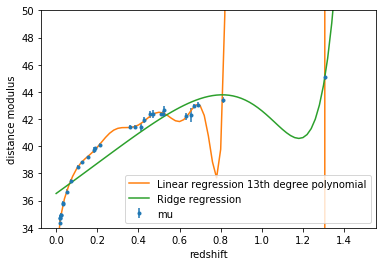

In [55]:
# We use Ridge regression from scikit-learn
from sklearn.linear_model import Ridge

# For this example we will use a 13th degree polynomial.
degree = 13

# We create the polynomial design matrix for our data.
X = polynomial_basis (df_sm["z"], degree)

# Ridge regression: define the model, fit it and predict.
ridge_model = Ridge (alpha = 1)   # alpha is equivalent to the lambda parameter.
ridge_model.fit(X, df_sm["mu"], sample_weight = 1./df_sm["sigma_mu"])
y_r = ridge_model.predict(polynomial_basis(x, degree))

# We define a polynomial of 13th degree and fit it to the data.
#p13_fit = np.polyfit(df_sm["z"], df_sm["mu"], 13, w = 1./df_sm["sigma_mu"])
#p13 = np.poly1d (p13_fit)
#y13 = p13(x)

p13_model = LinearRegression()
p13_model.fit(polynomial_basis (df_sm["z"], 13), df_sm["mu"], sample_weight = 1./df_sm["sigma_mu"])
y13 = p13_model.predict(polynomial_basis (x, 13))

pl.clf()
#pl.plot(df_sm['z'], df_sm['mu'],"o", markersize = 3, alpha = 0.5)
pl.errorbar(df_sm['z'], df_sm['mu'], fmt = ".", yerr = df_sm['sigma_mu'])
pl.plot(x, y13, label = "Linear regression 13th degree polynomial")
pl.plot(x, y_r, label = "Ridge regression")
pl.xlabel ("redshift")
pl.ylabel("distance modulus")
pl.legend(loc = "lower right")
pl.ylim([34, 50])
pl.show()

### LASSO Regression

Least absolute shrinkage and selection (LASSO) extends the idea of adding a prior by using a $L_1$ norm  for the regularization:

$L_\mathrm{LASSO} = (Y - M\boldsymbol{\theta})^TC^{-1}(Y-M\boldsymbol{\theta}) + \lambda|\boldsymbol{\theta}|$,

where $|\boldsymbol{\theta}| = \sum |\theta_i|$ penalizes the absolute value of $\boldsymbol{\theta}$:

$\sum |\theta_i| < s$

An important feature of LASSO is that imposes sparsity on the regression model. This can be apreciated by looking at the following geometrical interpretation:

<img src = images/LASSO.jpg>

The LASSO penalty preferentially selects regions of the likelihood parameter space that coincide with one of the vertices defined by the regularization. This means setting one or more of the parameters defining our model to zero, hence, reducing the complexity of the model.

A disadvantage of LASSO over Ridge regression is that there is no close form solution for the optimization problem. Nevertheless, LASSO regression is a convex optimization problem, and is solved numerically.

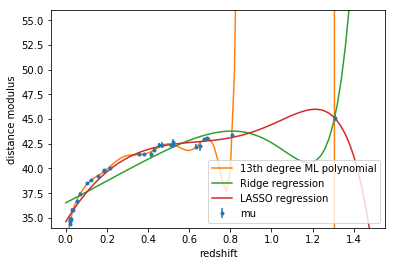

In [60]:
# Now we fit a LASSO regression model using scikit-learn
from sklearn.linear_model import Lasso

# Lasso regression: define the model, fit it and predict.
lasso_model = Lasso (alpha = 0.00001)   # alpha is equivalent to the lambda parameter.
lasso_model.fit(X, df_sm["mu"])
y_l = lasso_model.predict(polynomial_basis(x, degree))

pl.clf()
#pl.plot(df_sm['z'], df_sm['mu'],"o", markersize = 3, alpha = 0.5)
pl.errorbar(df_sm['z'], df_sm['mu'], fmt = ".", yerr = df_sm['sigma_mu'])
pl.plot(x, y13, label = "13th degree ML polynomial")
pl.plot(x, y_r, label = "Ridge regression")
pl.plot(x, y_l, label = "LASSO regression")
pl.xlabel ("redshift")
pl.ylabel("distance modulus")
pl.legend(loc = "lower right")
pl.ylim([34, 56])
pl.show()

We will now compare the obtained parameters for each method:

/Users/guille/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


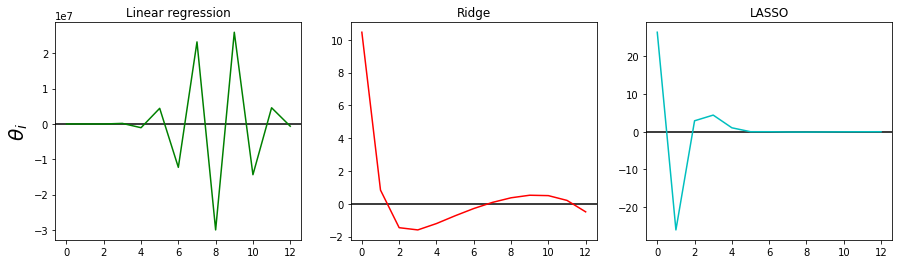

In [10]:
pl.clf()
fig, axs = pl.subplots (1, 3, figsize = (15, 4))
axs[0].axhline(0, c = "k")
axs[0].plot (np.arange(degree), p13_model.coef_, "g")
axs[0].set_title("Linear regression")
axs[0].set_ylabel(r"$\theta_i$", size = 20)
axs[1].axhline(0, c = "k")
axs[1].plot (np.arange(degree), ridge_model.coef_, "r")
axs[1].set_title ("Ridge")
axs[2].axhline(0, c = "k")
axs[2].plot (np.arange(degree), lasso_model.coef_, "c")
axs[2].set_title("LASSO")
pl.legend(loc = "lower right")
pl.show ()

### What regularization parameter should we use?

Ridge and LASSO regression need pthe regularization parameter $\lambda$ to be defined. Choosing a small value for $\lambda$ is equivalent to the maximum likelihood approach (i.e. risk of overfitting), while choosing a large $\lambda$ will result on a smooth model.

In order to sort this out, we can use a *cross-validation* methodology. The basic idea is to split our dataset into two (or more) subsets. We would use part of the dataset to fit our model, and evaluate it over a different fraction of the dataset never used for fitting. That way we can meassure how good our model extends to unseen data. The value for $\lambda$ can be choosen such that minimizes the cross-validated error. Furthermore, even the number of parameters of our model can be choosen using cross-validation!

## Cross-validation

_Cross validation_ is the process of validating a trained model over un-seen test data.
* Holdout Method:
 * Separate the dataset into two disjoint sets.
 * Fit over one set and validate over the other set.
 * Usually 2/3 for training, 1/3 for testing.
 * Calculate prediction errors over the test set. 

In [61]:
from sklearn.model_selection import train_test_split

x = np.arange (10)
y = x**2

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print "x train: ", X_train
print "y train: ", y_train
print "x test: ", X_test
print "y test: ", y_test

x train:  [9 1 6 7 3 0 5]
y train:  [81  1 36 49  9  0 25]
x test:  [2 8 4]
y test:  [ 4 64 16]


* K-fold:
 * Divide the dataset into k disjoint subsets (k-fold cross-validation).
 * Leave one set for testing and use the other k-1 for fitting.
 * Repeat k times using each subset once for validation. 

In [64]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
splits = kf.split(x)

print splits#.next()
for train, test in splits:
    print "----"
    print "train: ", train
    print "test: ", test
    print "x train: ", x[train]
    print "y train: ", y[train]
    print "x test: ", x[test]
    print "y test: ", y[test]

<generator object split at 0x11e9c4460>
----
train:  [4 5 6 7 8 9]
test:  [0 1 2 3]
x train:  [4 5 6 7 8 9]
y train:  [16 25 36 49 64 81]
x test:  [0 1 2 3]
y test:  [0 1 4 9]
----
train:  [0 1 2 3 7 8 9]
test:  [4 5 6]
x train:  [0 1 2 3 7 8 9]
y train:  [ 0  1  4  9 49 64 81]
x test:  [4 5 6]
y test:  [16 25 36]
----
train:  [0 1 2 3 4 5 6]
test:  [7 8 9]
x train:  [0 1 2 3 4 5 6]
y train:  [ 0  1  4  9 16 25 36]
x test:  [7 8 9]
y test:  [49 64 81]


* Random subsampling:
 * Randomly divide the data into train and test sets.
 * Perform the holdout method for each division.
 * Erros is calculated as the average of the errors obtained. 

In [65]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=3, test_size=0.3,random_state=0)
splits = ss.split(x)

print splits#.next()
for train, test in splits:
    print "----"
    print "train: ", train
    print "test: ", test
    print "x train: ", x[train]
    print "y train: ", y[train]
    print "x test: ", x[test]
    print "y test: ", y[test]

<generator object split at 0x11df42f00>
----
train:  [9 1 6 7 3 0 5]
test:  [2 8 4]
x train:  [9 1 6 7 3 0 5]
y train:  [81  1 36 49  9  0 25]
x test:  [2 8 4]
y test:  [ 4 64 16]
----
train:  [2 9 8 0 6 7 4]
test:  [3 5 1]
x train:  [2 9 8 0 6 7 4]
y train:  [ 4 81 64  0 36 49 16]
x test:  [3 5 1]
y test:  [ 9 25  1]
----
train:  [4 5 1 0 6 9 7]
test:  [2 3 8]
x train:  [4 5 1 0 6 9 7]
y train:  [16 25  1  0 36 81 49]
x test:  [2 3 8]
y test:  [ 4  9 64]


* Bootstrap:
 * Generate m subsets of size n’< n, sampling from D randomly with replacement.
 * Records not included in the training set become part of the test set.
 * On average, a bootstrap training set of size n contains 63.2% of the records in the original data. 

In [66]:
N_train = 10

train_ids = np.random.randint(x.shape[0], size=N_train)
print train_ids
unique = np.unique(train_ids)
print "unique: ", unique
is_in_unique = np.in1d(np.arange(x.shape[0]), unique)
print is_in_unique

test_ids = np.arange(x.shape[0])[np.logical_not(is_in_unique)]
print "ids train:", train_ids
print "ids test:", test_ids

[6 0 0 7 0 8 7 9 4 0]
unique:  [0 4 6 7 8 9]
[ True False False False  True False  True  True  True  True]
ids train: [6 0 0 7 0 8 7 9 4 0]
ids test: [1 2 3 5]


As an example, we will use holdout cross-validation to decide what the optimal number of parameters is for a linear polynomial regression:

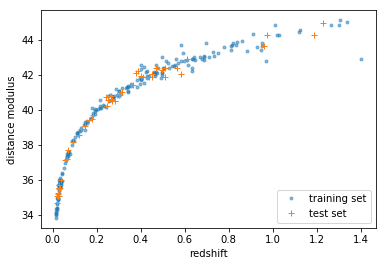

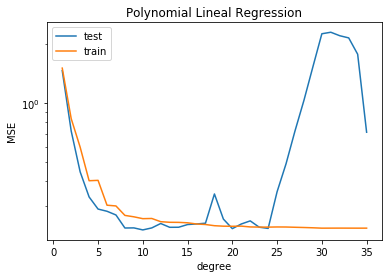

In [68]:
from sklearn.linear_model import LinearRegression

# We will use 200 out of the 526 points from the original data to fit the model and the rest for testing it
N_train = 200
ss = ShuffleSplit(n_splits=1, train_size=N_train, random_state=0)
splits = ss.split(df["z"])
train_ids, test_ids = splits.next()

z_train, mu_train, s_mu_train = df["z"][train_ids], df["mu"][train_ids], df["sigma_mu"][train_ids]
z_test, mu_test, s_mu_test = df["z"][test_ids], df["mu"][test_ids], df["sigma_mu"][test_ids]

# Lets plot training and testing data
pl.clf()
pl.plot(z_train, mu_train, ".", label = "training set", alpha = 0.5)
pl.plot(z_test, mu_test, "+", label = "test set")
pl.xlabel ("redshift")
pl.ylabel("distance modulus")
pl.legend(loc = "lower right")
pl.show()

# We will try models for different order polynomials from 1 to 35
degs = np.arange(1, 36, 1)

model = LinearRegression()

mse = []
mse_train = []
for deg in degs:
    # We create the polynomial design matrix for our data.
    X_train = polynomial_basis (z_train, deg)
    X_test = polynomial_basis (z_test, deg)
    model.fit(X_train, mu_train, sample_weight = 1./s_mu_train)
    ypol = model.predict(X_test)
    
    #y = model.predict(z_test[:, None])
    mse.append(((mu_test - ypol)**2).sum()/len(ypol))

    y_train = model.predict(X_train)
    #y_train = pol(z_train)
    mse_train.append(((mu_train - y_train)**2).sum()/len(y_train))
    
pl.clf()
pl.plot(degs, np.sqrt(mse), label = "test")
pl.plot(degs, np.sqrt(mse_train), label = "train")
pl.xlabel ("degree")
pl.ylabel ("MSE")
pl.yscale("log")
pl.legend(loc = "best")
pl.title ("Polynomial Lineal Regression")
pl.show()

### Papers for next week

* Zou, H., & Hastie, T. (2005). Regularization and variable selection via the elastic net. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 67(2), 301-320. Cecilia Huerta
* Efron, B., Hastie, T., Johnstone, I., & Tibshirani, R. (2004). Least angle regression. The Annals of statistics, 32(2), 407-499. Manuel Pérez

In [70]:
import numpy as np
np.random.random()* 3+0.5

2.4937092654731714

Next week:
* Felipe Glaria
* Joaquin Cardenas
